In [48]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [49]:
# function to test machine learning algorithms from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

def testMod(X,y,mod):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)
    mod.fit(X_train,y_train)
    pred = mod.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    r2 = r2_score(y_test,pred)
    s = "R2={:.2f} RMSE={:.2f}".format(r2,rmse)
    plt.figure()
    plt.gca().set_aspect('equal')
    hb = plt.hexbin(y_test, pred, gridsize=20, cmap='cool', bins='log')
    cb = plt.colorbar(hb, label='log10(N)')
    _,top = plt.ylim()
    _,right = plt.xlim()
    m = max(top,right)
    plt.plot((0, m), (0, m), 'k-')
    plt.xlim(0,m)
    plt.ylim(0,m)
    plt.title(s)
    plt.xlabel('test')
    plt.ylabel('prediction')
    return mod

In [50]:
def plotModYear(year):
    fig = plt.figure(figsize=(12, 5), dpi=100)

    (ax1, ax2) = fig.subplots(ncols=2, sharey=True)

    ax1.plot(Y.dates,Y.scf, marker='.' , linestyle = 'None', label='Observed from MODIS')
    ax1.plot(datesSel,xmod2, marker='.', linestyle = 'None', label='Predicted from UERRA')
    ax1.set_ylabel('Snow cover fraction')
    ax1.set_xlabel('Time')
    
    ax2.plot(Y.dates,Y.scf, marker='.' , linestyle = 'None', label='Observed from MODIS')
    ax2.plot(datesSel,xmod2, marker='.', linestyle = 'None', label='Predicted from UERRA')
    ax2.set_xlabel('Time')

    ax1.set_title('{}-{}'.format(year,year+1))
    ax2.set_title('{}-{}'.format(year+1,year+2))
    ax1.set_xlim([date(year,11,1), date(year+1,7,1)])
    ax2.set_xlim([date(year+1,11,1), date(year+2,7,1)])
    ax1.set_ylim([0,1])
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.legend()

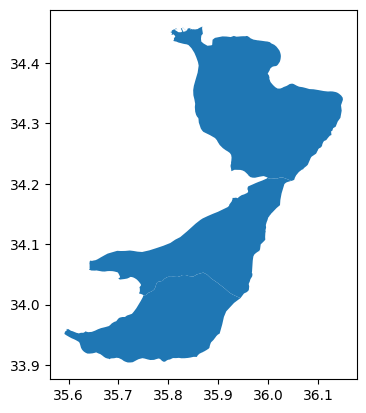

In [63]:
sf = gpd.read_file('shp/LebanonCatchements/LebanonCatchments.shp')
sf.plot();

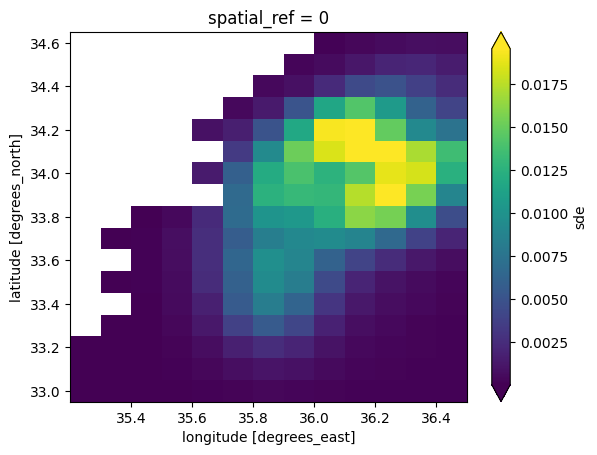

In [77]:
# correct CRS of UERRA dataset is 
"#crs ="+proj=longlat +datum=WGS84 +no_defs
dsFullExtent = xr.open_mfdataset('DataExport\Lebanon-Snow-Cover-Data\*.nc')
#dsFullExtent.rio.write_crs(crs, inplace=True)
dsFullExtent.sde.mean(dim='time').plot(robust=True);

<xarray.DataArray 'sde' (latitude: 2, longitude: 2)>
dask.array<mean_agg-aggregate, shape=(2, 2), dtype=float32, chunksize=(2, 2), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 35.95 36.05
  * latitude     (latitude) float32 34.4 34.3
    spatial_ref  int32 0


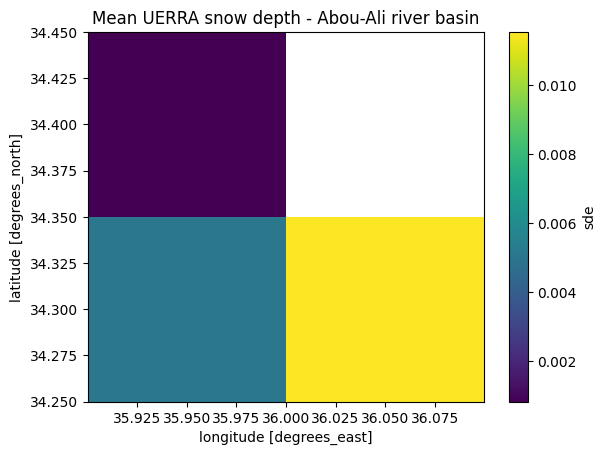

<xarray.DataArray 'sde' (latitude: 1, longitude: 2)>
dask.array<mean_agg-aggregate, shape=(1, 2), dtype=float32, chunksize=(1, 2), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 35.75 35.85
  * latitude     (latitude) float32 34.0
    spatial_ref  int32 0


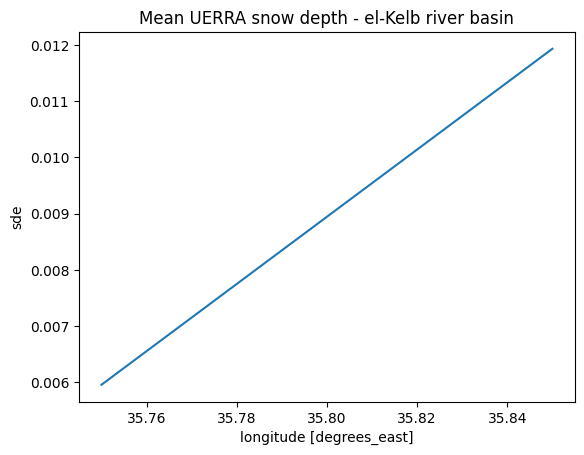

<xarray.DataArray 'sde' (latitude: 1, longitude: 2)>
dask.array<mean_agg-aggregate, shape=(1, 2), dtype=float32, chunksize=(1, 2), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 35.85 35.95
  * latitude     (latitude) float32 34.1
    spatial_ref  int32 0


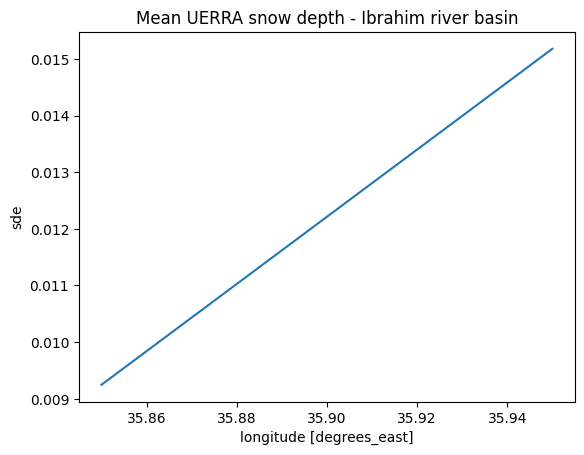

In [106]:
# Open the shapefile and set the CRS
shapefile_path = "./shp/LebanonCatchements/LebanonCatchments.shp"
sf = gpd.read_file(shapefile_path)
crs = sf.crs.to_string()
dsFullExtent.rio.write_crs(crs, inplace=True)
# Clip the raster to the shapefile
for ibv in range(len(sf)):
    bv = sf.loc[[ibv]]
    bvname = bv.BASINNAME.values[0]
    ds = dsFullExtent.rio.clip(bv.geometry)
    ds.sde.mean(dim='time').plot()
    print(ds.sde.mean(dim='time'))
    plt.title('Mean UERRA snow depth - {} river basin'.format(bvname))
    plt.show()

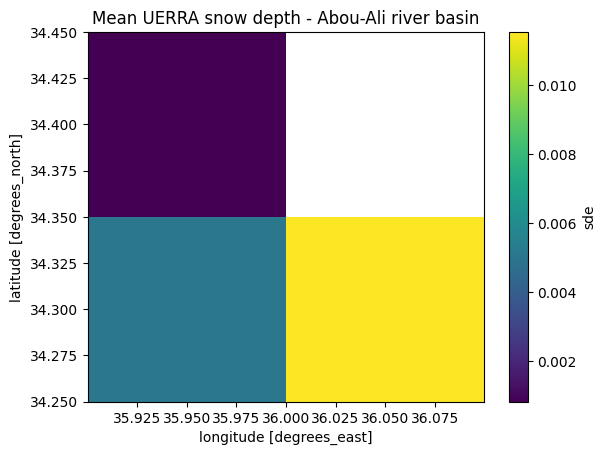

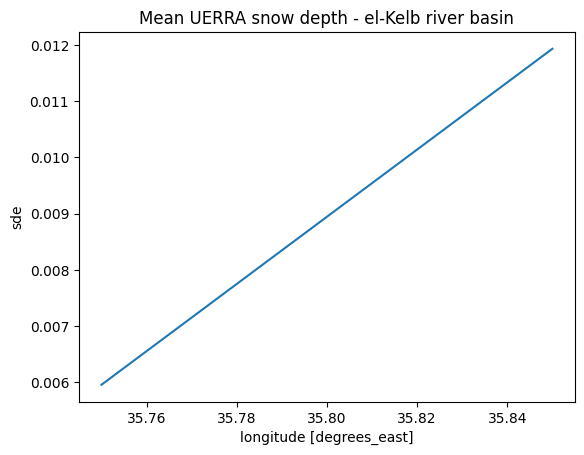

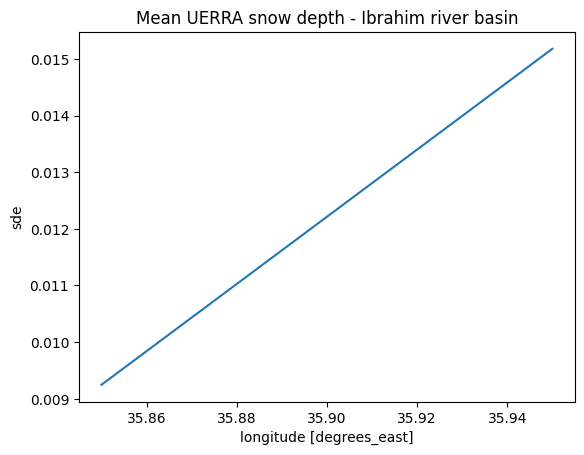

In [108]:
for ibv in range(0,len(sf)):
    fig = plt.figure()    
    bv = sf.loc[[ibv]]
    bvname = bv.BASINNAME.values[0]
    crs=bv.crs
    dsFullExtent.rio.write_crs(crs, inplace=True)
    ds = dsFullExtent.rio.clip(bv.geometry)
    ds.sde.mean(dim='time').plot()
    plt.title('Mean UERRA snow depth - {} river basin'.format(bvname));

<Figure size 640x480 with 0 Axes>

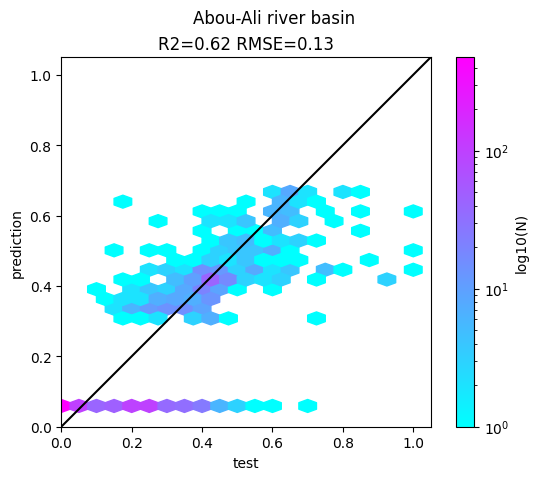

<Figure size 640x480 with 0 Axes>

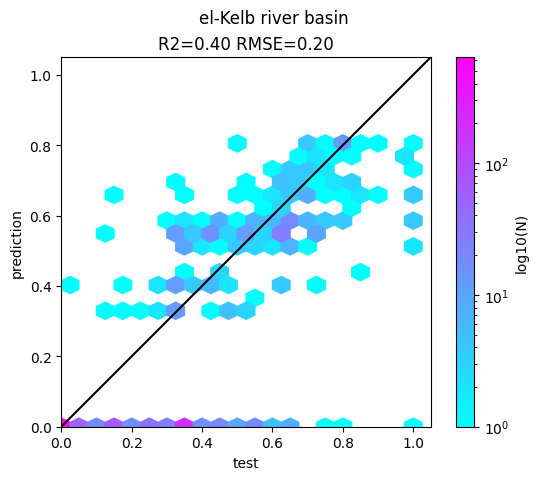

<Figure size 640x480 with 0 Axes>

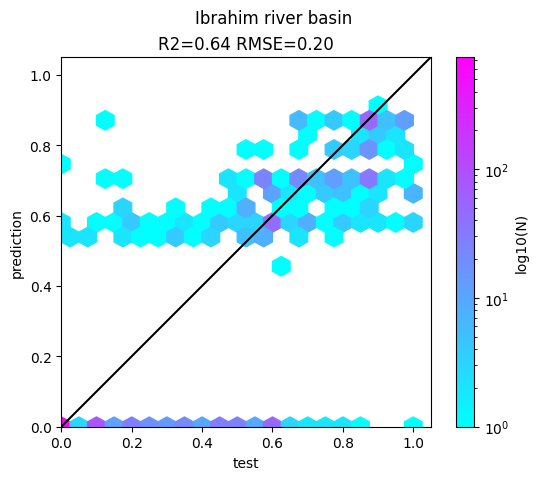

In [116]:
from sklearn.neighbors import KNeighborsRegressor


for ibv in range(0,len(sf)):
    bv = sf.loc[[ibv]]
    bvname = bv.BASINNAME.values[0]
    fig = plt.figure()
    ds = dsFullExtent.rio.clip(bv.geometry.values, bv.crs)
    f = '{}SCF'.format(bvname)
    # create date and scf arrays from Modis csv
    dfscf = pd.read_csv('Modis/LebanonBasins/{}.csv'.format(f), index_col=0, decimal='.')
   
    #dfscf = pd.read_csv('Modis/AlpsScf01July.csv', index_col=0)
    doy = dfscf.index
    
    dfdate = pd.DataFrame([pd.to_datetime(doy-1, unit='D', origin=str(y)) for y in dfscf.columns]).transpose()
    dfdate.index = dfscf.index
    dfdate.columns = dfscf.columns
    dates = dfdate.transpose().stack(dropna=False)
    scf = dfscf.transpose().stack(dropna=False)
    # Make Y dataframe with SCF values to predict
    Y = pd.concat([dates,scf], axis=1, keys=['dates','scf'])
    Y.dropna(inplace=True)
    # Use date at 6h as index to match Uerra convention
    Y.index = [d.replace(hour=10)  for d in Y.dates] #.to_datetime64()
    # create datesSel vector containing matching dates from both datasets
    datesSel = list(set(Y.index.values).intersection(ds.time.values))
    datesSel.sort()
    # reduce UERRA dataset to these dates
    dsSel = ds.sel(time=datesSel)
    # Make X array with predictors
    X = dsSel['sde'].values.reshape(len(datesSel),-1)
    # remove nodata [TODO: APPLY MODIS AOI MASK]
    ix = np.all(np.isnan(X),axis=0)
    # This is the array of training data (snow depth of every cell)
    X = X[:,~ix]
    # This is the array of target values (snow cover fraction)
    y = Y.loc[datesSel].scf
    
    mod = testMod(X,y,GradientBoostingRegressor(loss="absolute_error"))
    plt.suptitle('{} river basin'.format(bvname))
    # save model
    with open('mod{}.pickle'.format(f), 'wb') as handle:
        pickle.dump(mod, handle)

C:\Users\rami.ismail\AppData\Local\Temp\ipykernel_31552\2192209499.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 5), dpi=100)


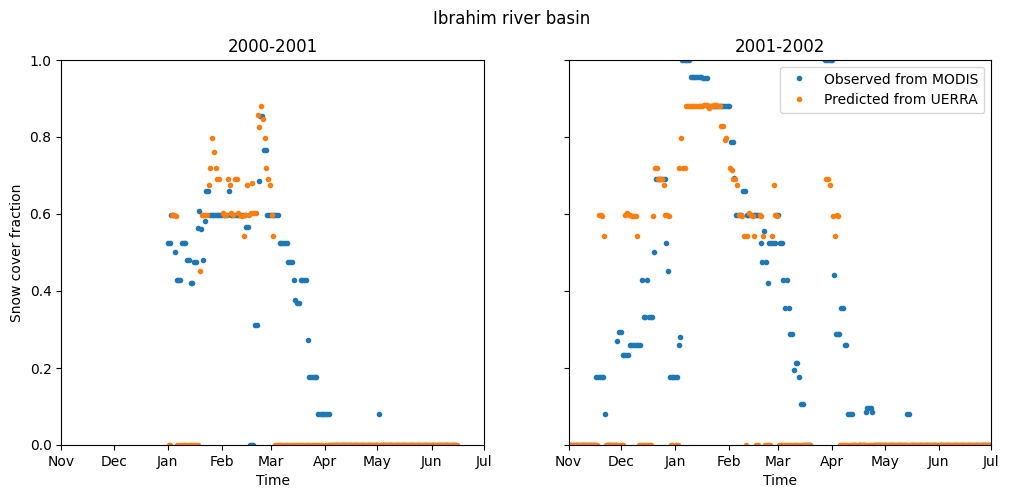

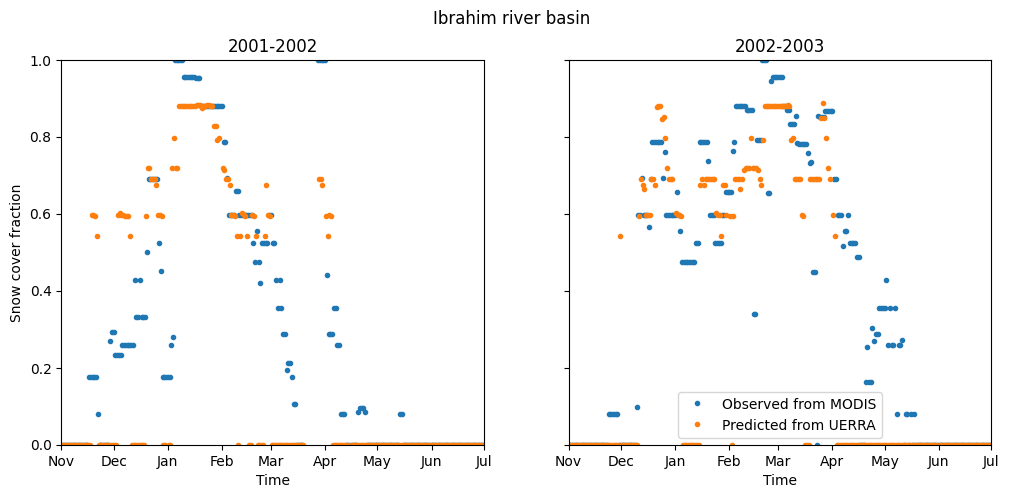

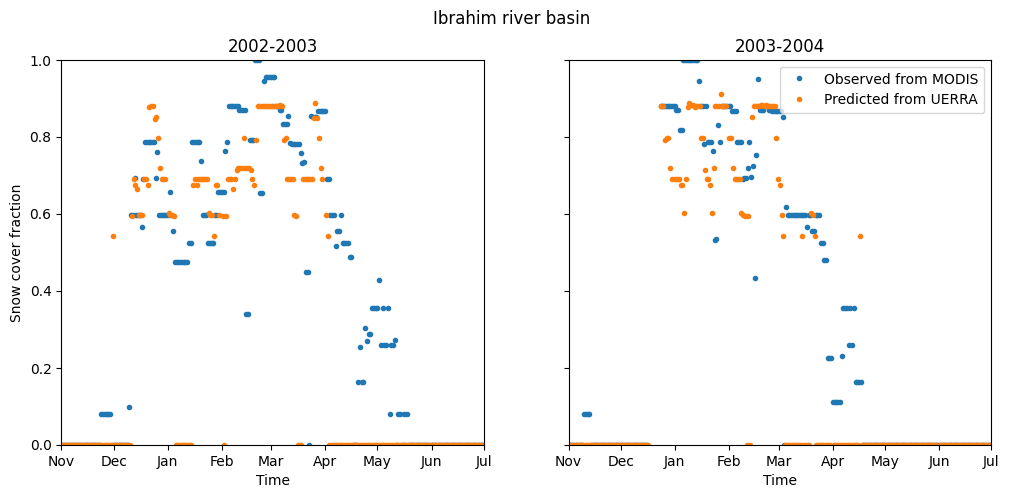

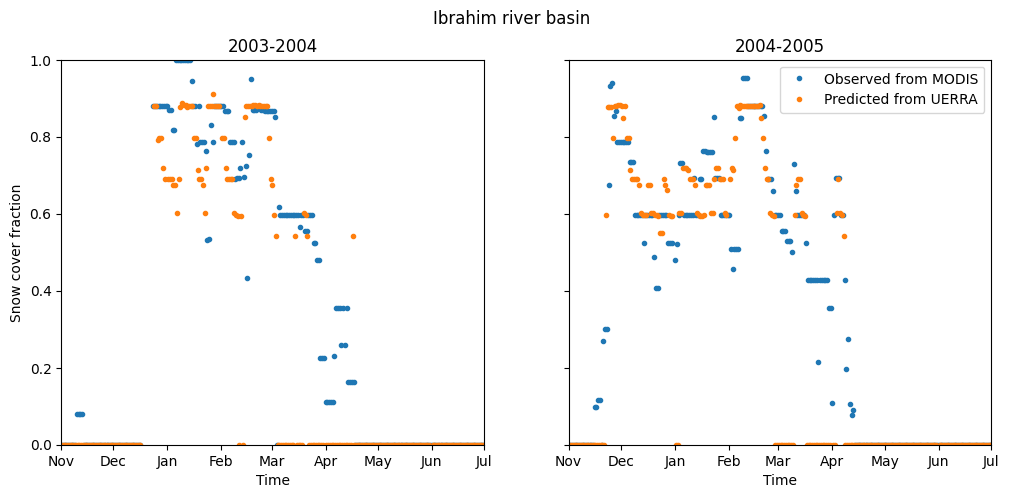

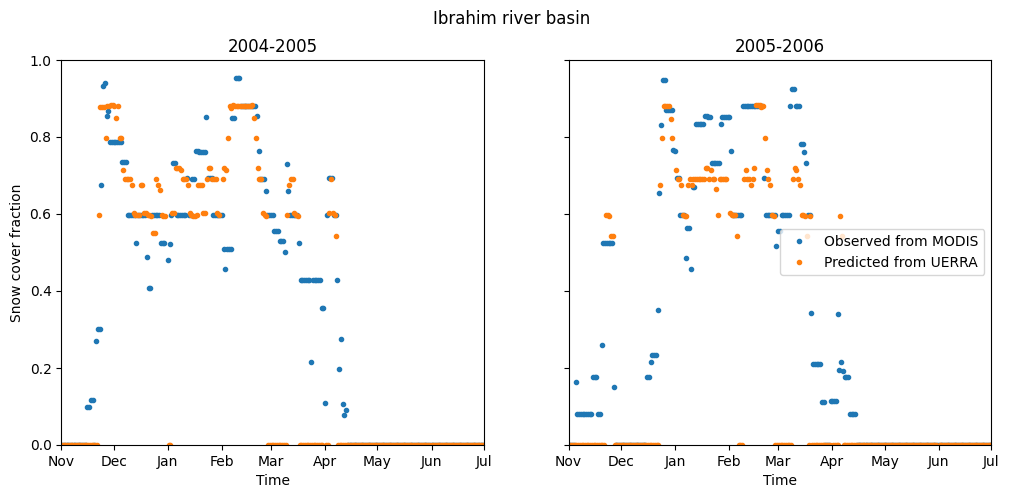

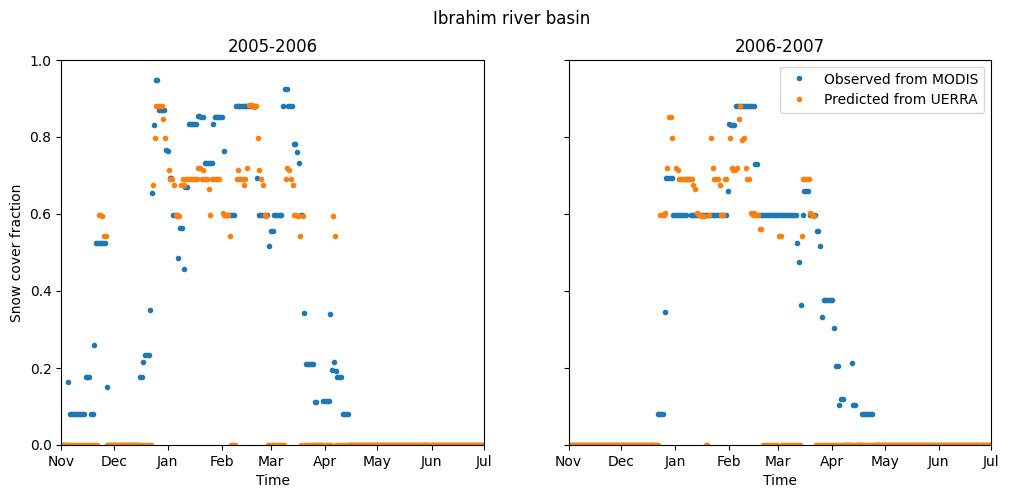

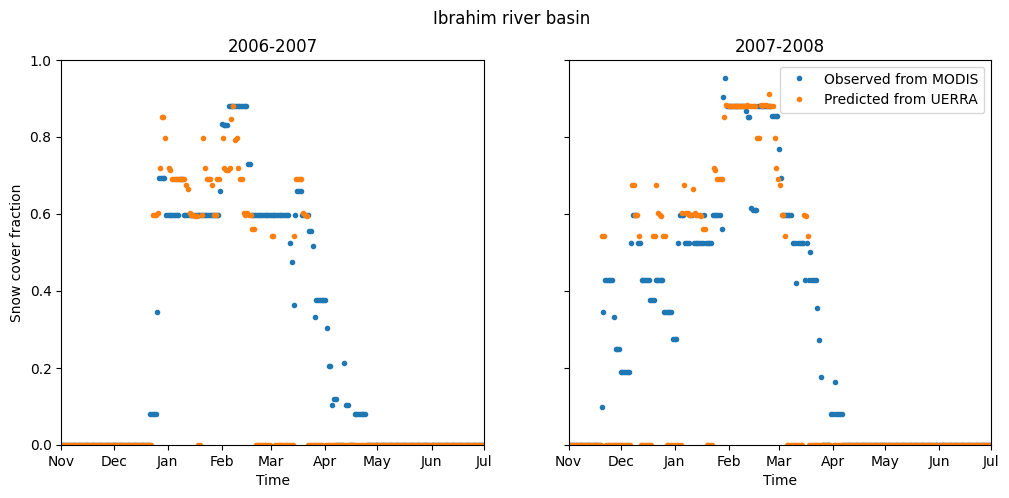

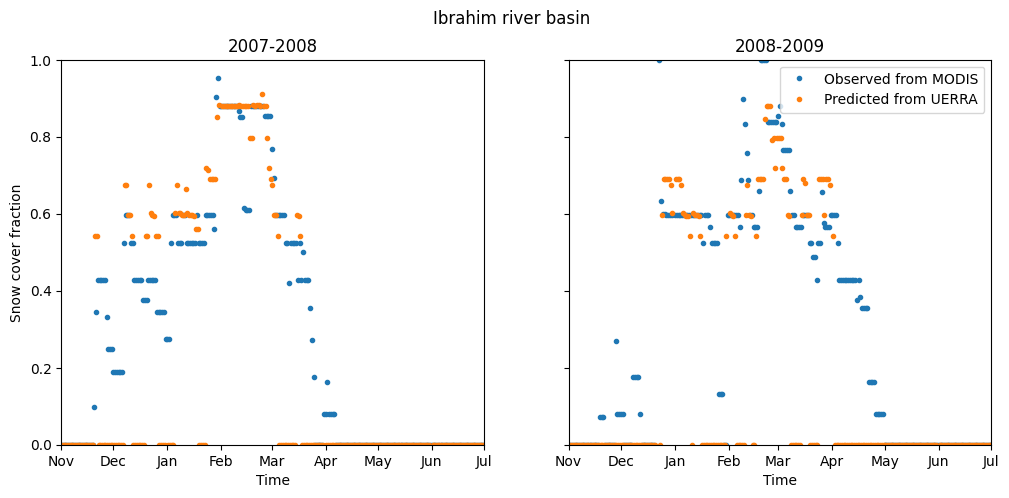

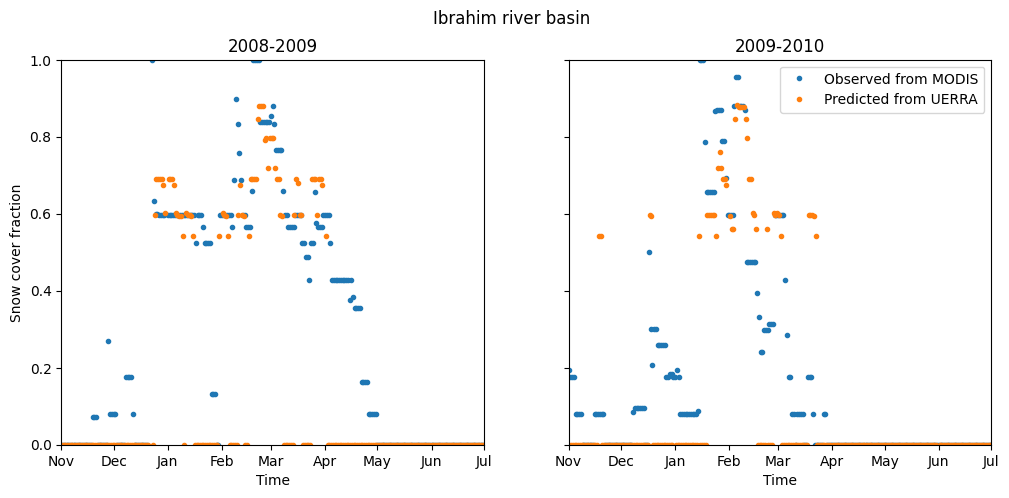

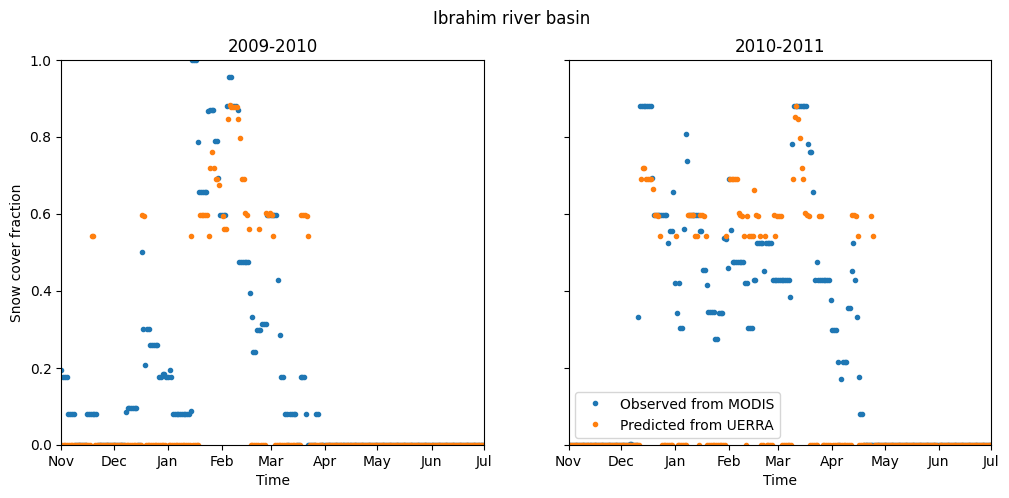

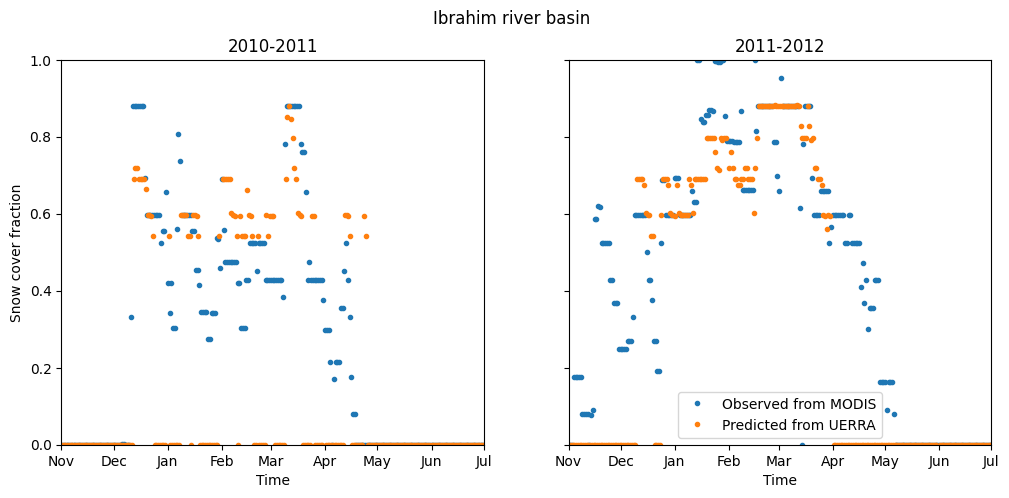

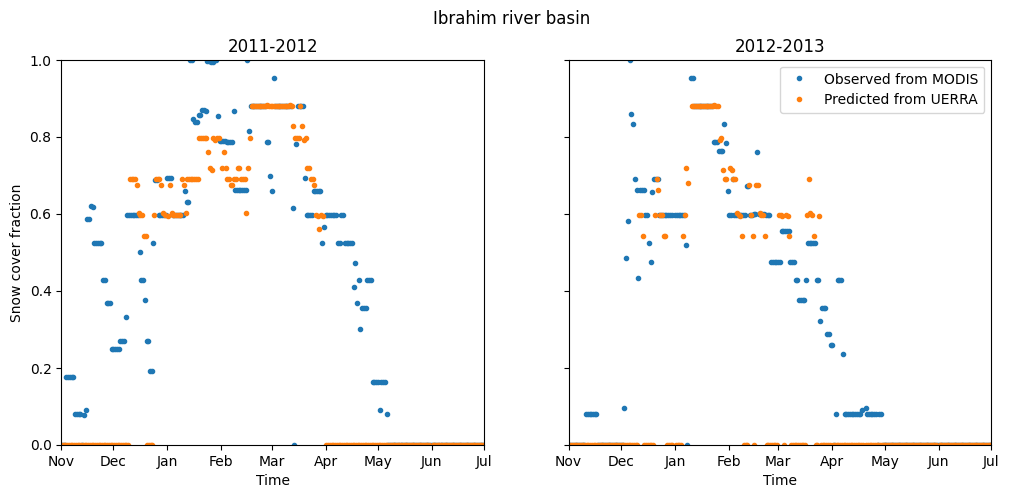

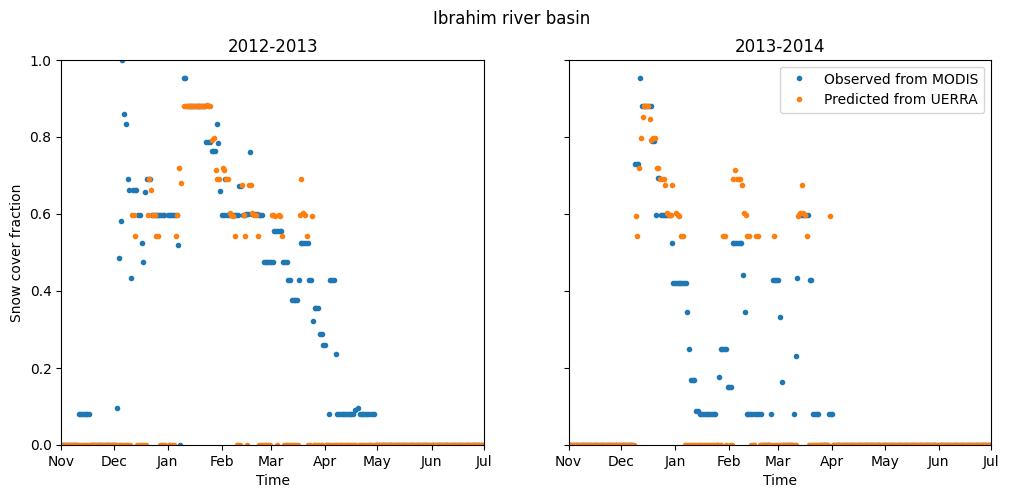

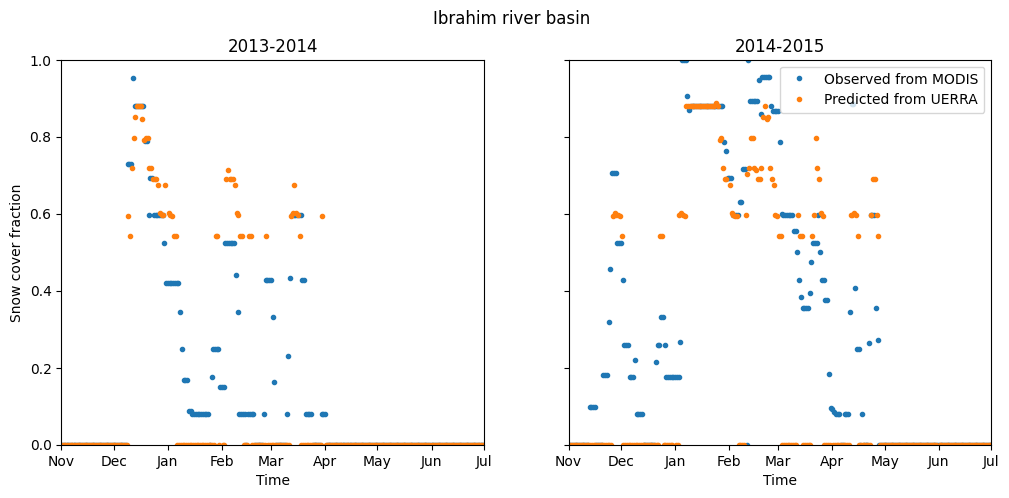

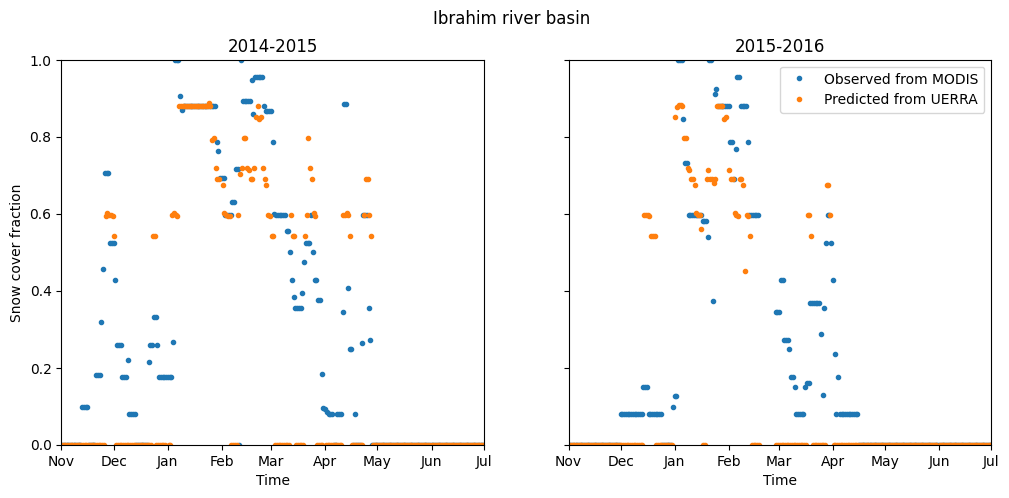

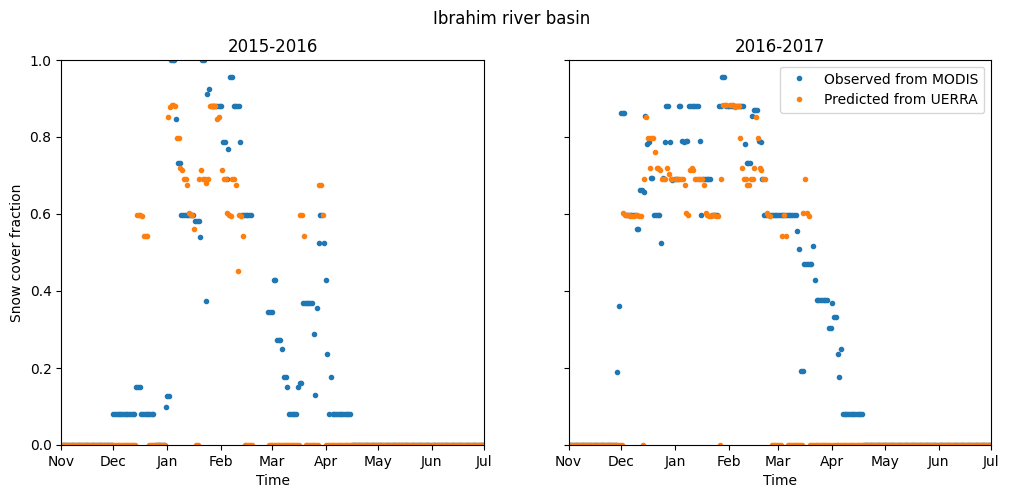

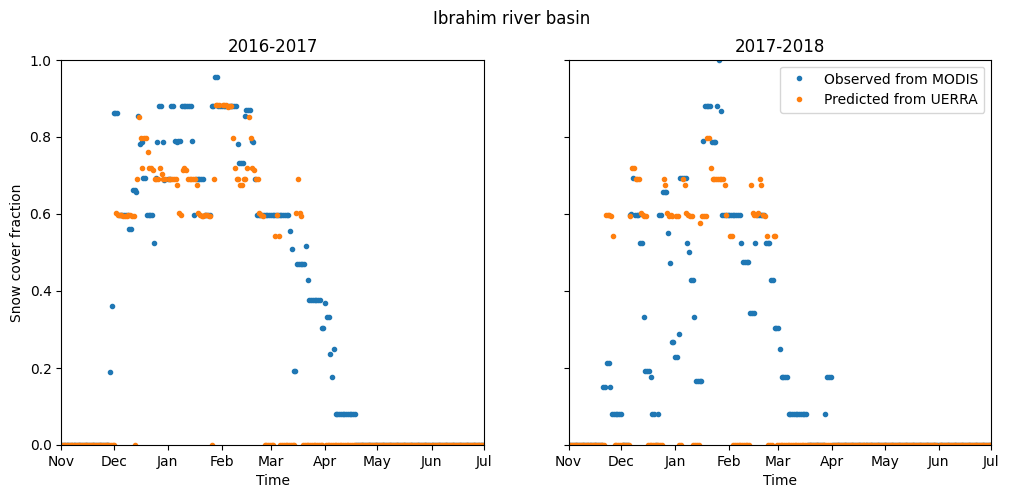

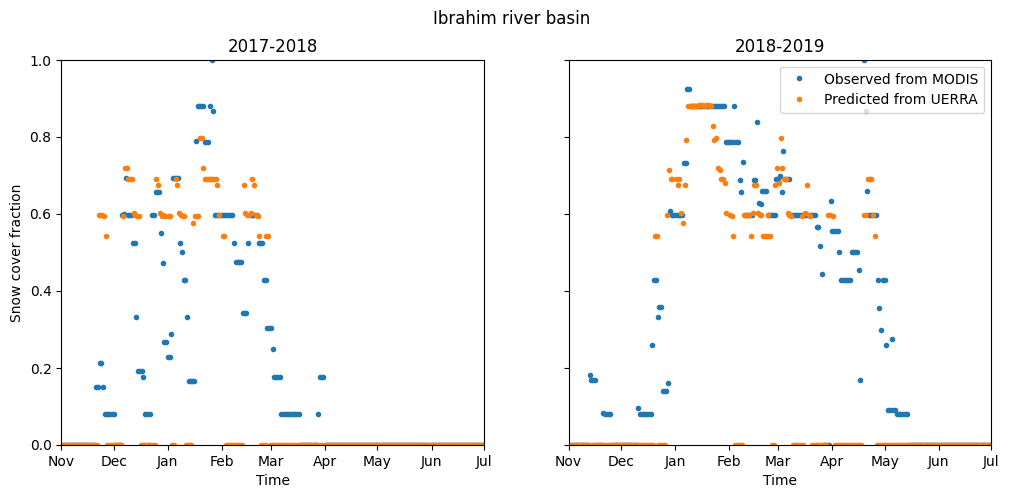

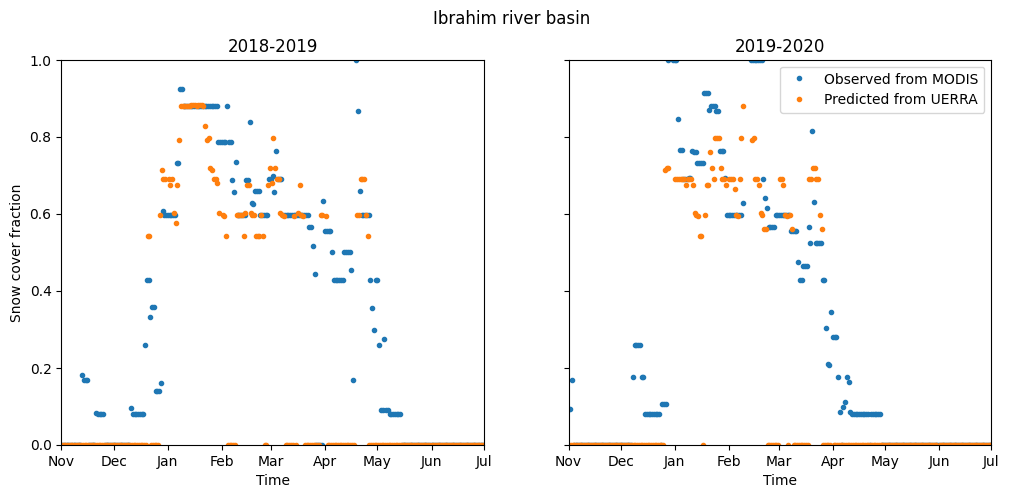

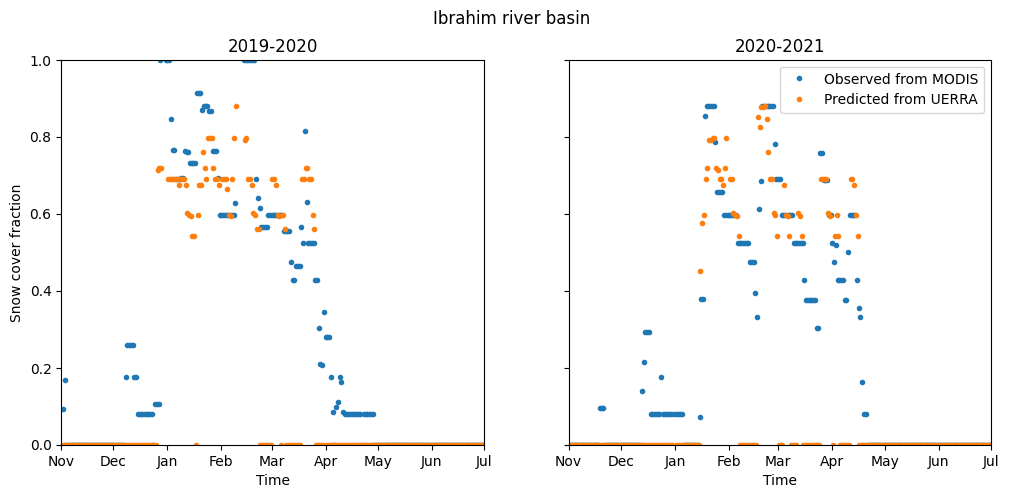

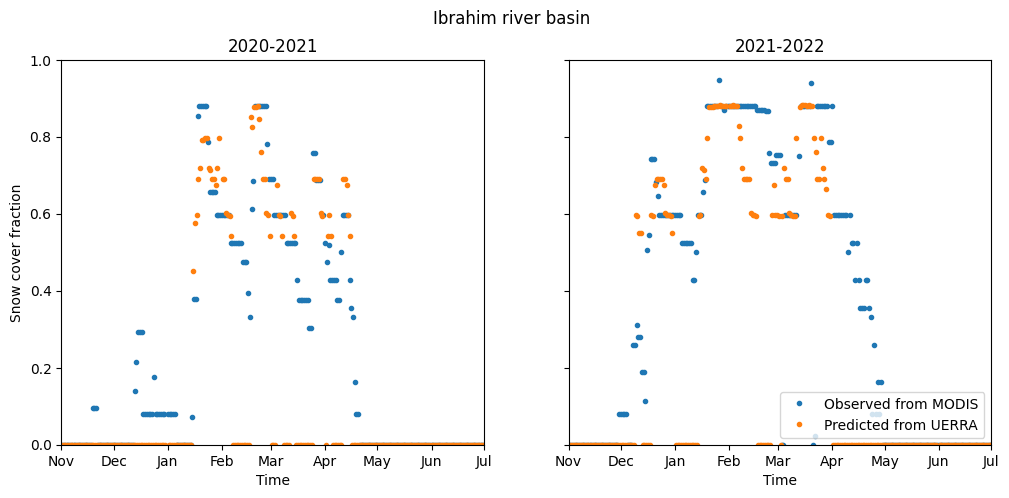

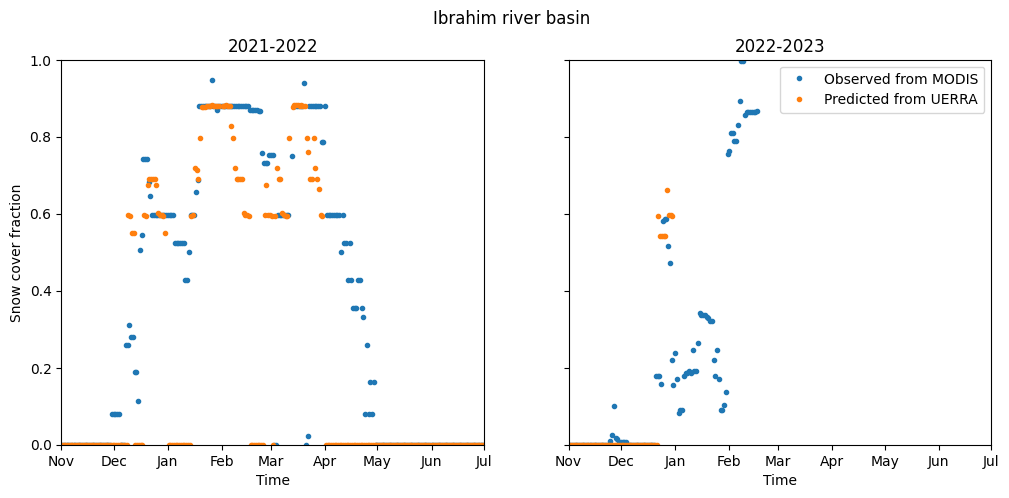

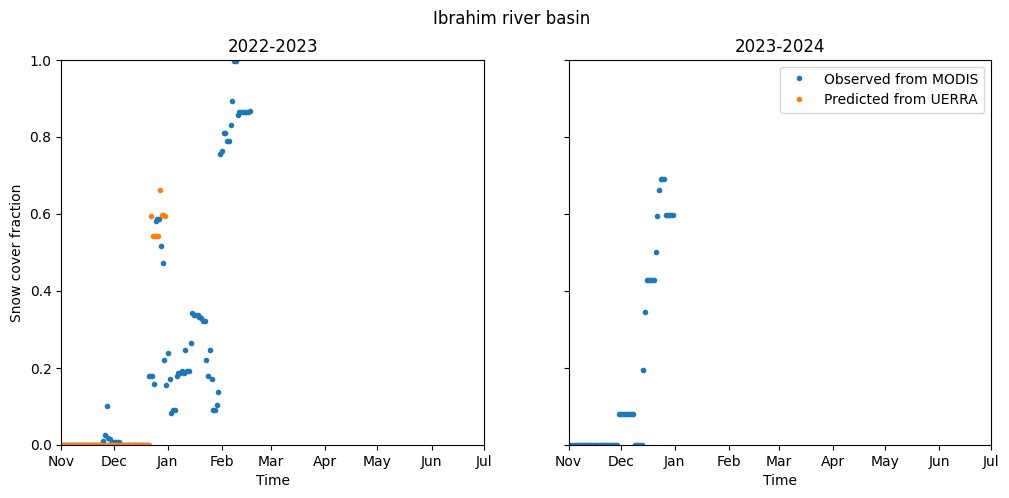

In [117]:
xmod2 = mod.predict(X)
for year in range(2000,2023):
    plotModYear(year)
    plt.suptitle('{} river basin'.format(bvname))